# Lecture 13:  Integral Transforms and D/FFT
----

### Sections

* [Introduction](#Introduction)
* [Learning Goals](#Learning-Goals)
* [On Your Own](#On-Your-Own)
    * [The Fourier Transform](#The-Fourier-Transform)
    * [The Discrete Fourier Transform](#The-Discrete-Fourier-Transform)
* [In Class](#In-Class)
    * [DFT with Numpy Functions](#DFT-with-Numpy-Functions)
    * [Interactive Microscopy Demonstration](#Interactive-Microscopy-Demonstration)
* [Homework](#Homework)
* [Summary](#Summary)
* [Looking Ahead](#Looking-Ahead)
* [Reading Assignments and Practice](#Reading-Assignments-and-Practice)

### Introduction
----

I have examined a few texts and web sites that explain the Fourier transform and the Laplace transform.  I've also tried to wrap my head around a more common-language definition of an "Integral Transform" to aid in understanding - but it continues to elude me.  

There is a very matter of fact definition of "Integral Transform" on Mathworld and I've seen it repeated in various places:

$$g(\alpha) = \int_{a}^{b} f(t) K(\alpha,t) dt $$

These descriptions state that any relationship between f and g such as the one above are generically "Integral Transforms" that map the two functions into each other.  

There are discussions on existence, integrability, and inversion that are necessary to raise, but, for us (right now) we will proceed without further consideration.

The diffusion texts that I've consulted resort to the Laplace transform to remove the time dependence from Fick's second law.  The equations are mapped into a different coordinate system that reduces the partial differential equation to an ODE - thereby making it more easily solved.

The other use of an integral transform, the Fourier Transform, is often used to describe diffraction phenomena.  There are additional physics involved with regards to the geometry of the specimen and the interaction of the electron waves in matter, but, at the core of the description of diffraction is the Fourier Transform.

[Top of Page](#Sections)

### Learning Goals
----

* Be comfortable with the idea of an integral transform.
* Study how to implement the Fourier, and Discrete Fourier transforms.
* Be able to conceptually explain how HRTEM works.

[Top of Page](#Sections)

### On Your Own
----

Here are some reminders about special symbols and the result of an integration:

In [2]:
import sympy as sp
sp.init_printing(use_latex=True)

In [4]:
x,y,z,t = sp.symbols('x y z t')
omega = sp.symbols('omega', positive=True)
c = sp.symbols('c')

In [ ]:
sp.I**2

In [ ]:
sp.log(sp.E)

In [ ]:
sp.Integral(sp.E**(sp.I*omega*t),t)

In [ ]:
sp.integrate(sp.E**(sp.I*omega*t),t)

Where we assume there is no zero frequency - hence the assumption `positive=True` above.

[Top of Page](#Sections)

#### The Fourier Transform

If we extend the notion of a Fourier series to larger and larger domains, the frequency spectrum becomes more finely divided.  Recall the argument in the trigonometric terms in the functions that computed the even and odd terms:

$$ \frac{n \pi (\omega +c)}{d} $$

n was the order of the amplitude, c the offset, d the domain width.

If we let the domain go to infinity (implying that the function is not periodic) then each frequency component becomes more finely divided as n/d.  

Some of the surveyed texts will point out that the non-periodic function and its frequency spectrum are related by the Fourier transform:

$$ \hat{f}(\omega) = \sqrt{\frac{1}{2\pi}} \int^{+\infty}_{-\infty} f(t) \exp[-i \omega t] dt $$

This results in a mapping of the function f(t) into frequency space.  Let us plot a function with a value of $1$ in some specified interval.

<IPython.core.display.Javascript object>


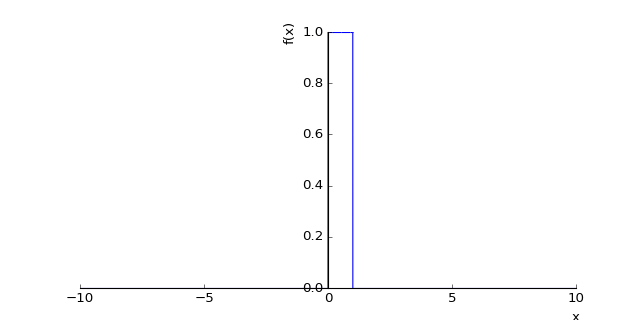

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 4

p = sp.Piecewise((0,x<0),(1,x<1),(0,True))
sp.plot(p)

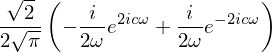

In [6]:
a = sp.sqrt(1/(2*sp.pi))*sp.integrate(1*sp.exp(-sp.I*2*omega*x),(x,-c,c))
a

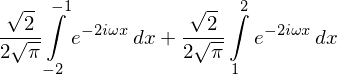

In [38]:
compositeIntegral = sp.sqrt(1/(2*sp.pi))*sp.Integral(1*sp.exp(-sp.I*2*omega*x),(x,1,2)) + \
sp.sqrt(1/(2*sp.pi))*sp.Integral(1*sp.exp(-sp.I*2*omega*x),(x,-2,-1))
compositeIntegral

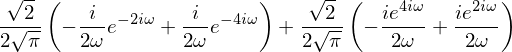

In [47]:
om = compositeIntegral.doit()
om

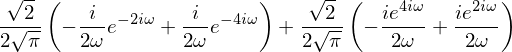

In [48]:
om

<IPython.core.display.Javascript object>


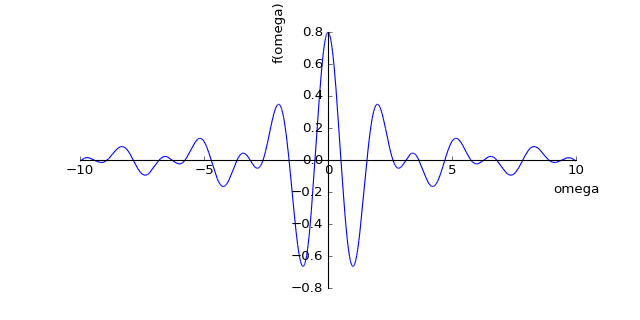

In [41]:
sp.plot(om.rewrite(sp.sin).expand())

In [16]:
def awesomeFunction(d=4.0, w=1.0):
    sp.sqrt(1/(2*sp.pi))*sp.Integral(1*sp.exp(-sp.I*2*omega*x),\
                                     (x,-(d+w),-(d-w))) + \
    sp.sqrt(1/(2*sp.pi))*sp.Integral(1*sp.exp(-sp.I*2*omega*x),\
                                     (x,(d-w),(d+w)))
    return compositeIntegral.doit()

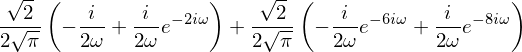

In [17]:
awesomeFunction(10.,2.)

There is a little bit of weirdness here.  We get back an answer in exponential form.  We can ask for this form using sines and cosines with the `rewrite` method.  Furthermore - we can simplify it further with the expand function.  This is something that I didn't have to do with Mathematica - I don't know the algorithms at all so I can't offer any commentery on this.  

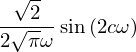

In [7]:
solution = sp.expand(a.rewrite(sp.sin))
solution

Here we can use the `subs` (substitution) method to set the value of `c`.  In my opinion this is one of the more insanely useful parts of `sympy`.  I plotted the square of the function since the intensity of a diffracted wave is the square of the amplitude.

In [ ]:
sp.plot(solution.subs(c,1)**2);

[Top of Page](#Sections)

#### The Discrete Fourier Transform

We'll start by doing this by hand.  The discrete Fourier Transform is defined [here](http://en.wikipedia.org/wiki/Discrete_Fourier_transform).  Other resources such as Numerical Recipes, the Python help files and many other websites give the formula.

Knowing what we know about matrix algebra, the DFT is straightforward to implement in Python/Numpy.  It may not be memory efficient or fast, but, it is easy to implement.

It is often instructive to review other implementations of the DFT to help you learn how these are computed.  I will be modeling this implementation after one found [here](http://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/).  The DFT definitions are (following the notation of the blog post):

Forward DFT:

$$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}$$

Inverse DFT:

$$x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{i~2\pi~k~n~/~N}$$

You know - I've read a few other texts and Jake Vanderplas' explanation is really wonderful.  The next cell and the code that follows is taken right from JVP's Jupyter notebook:

----
For simplicity, we'll concern ourself only with the forward transform, as the inverse transform can be implemented in a very similar manner.  Taking a look at the DFT expression above, we see that it is nothing more than a straightforward linear operation: a matrix-vector multiplication of $\vec{x}$,

$$\vec{X} = M \cdot \vec{x}$$

with the matrix $M$ given by

$$M_{kn} = e^{-i~2\pi~k~n~/~N}$$

With this in mind, we can compute the DFT using simple matrix multiplication as follows:

In [6]:
import numpy as np
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [7]:
x = np.random.random(1024)
np.allclose(DFT_slow(x), np.fft.fft(x))

True

----
 

I think it would be instructive to symbolically expand the matrix above.  Because you might have missed how the code above (in particular `k*n`) leads to a two dimensional matrix.  It is matrix multiplication.  Switching to `sympy` symbols to expose the details we can do the following:

In [8]:
import sympy as sp
import numpy as np
sp.init_printing()

In [9]:
x = sp.Matrix(sp.symbols('x0:5'))
n = sp.Matrix(sp.symbols('n0:5'))
k = sp.Matrix(sp.symbols('k0:5')).T
N = sp.symbols('N')

M = (-sp.I*2*sp.pi*n*k/N).applyfunc(sp.exp)
M

⎡ -2⋅ⅈ⋅π⋅k₀⋅n₀    -2⋅ⅈ⋅π⋅k₁⋅n₀    -2⋅ⅈ⋅π⋅k₂⋅n₀    -2⋅ⅈ⋅π⋅k₃⋅n₀    -2⋅ⅈ⋅π⋅k₄⋅n₀
⎢ ─────────────   ─────────────   ─────────────   ─────────────   ────────────
⎢       N               N               N               N               N     
⎢ℯ               ℯ               ℯ               ℯ               ℯ            
⎢                                                                             
⎢ -2⋅ⅈ⋅π⋅k₀⋅n₁    -2⋅ⅈ⋅π⋅k₁⋅n₁    -2⋅ⅈ⋅π⋅k₂⋅n₁    -2⋅ⅈ⋅π⋅k₃⋅n₁    -2⋅ⅈ⋅π⋅k₄⋅n₁
⎢ ─────────────   ─────────────   ─────────────   ─────────────   ────────────
⎢       N               N               N               N               N     
⎢ℯ               ℯ               ℯ               ℯ               ℯ            
⎢                                                                             
⎢ -2⋅ⅈ⋅π⋅k₀⋅n₂    -2⋅ⅈ⋅π⋅k₁⋅n₂    -2⋅ⅈ⋅π⋅k₂⋅n₂    -2⋅ⅈ⋅π⋅k₃⋅n₂    -2⋅ⅈ⋅π⋅k₄⋅n₂
⎢ ─────────────   ─────────────   ─────────────   ─────────────   ────────────
⎢       N               N               N           

In [ ]:
M.dot(x)

Look at the shape of that matrix.  Look at each entry and what comprises each entry.

Now - think about the implications of the matrix multiplication above.  The best way I can explain it is to think of each frequency element projected into each point of the input vector - the matrix links `k` and `n`.  So - the contribution at each point is a sum of each frequency contribution...just like our dot product of functions.  My description is not satisfying to read - I'll work on it a bit more.

[Top of Page](#Sections)

### In Class
----

#### DFT with Numpy Functions

Let us start by reading the help file for a few new functions that we will be using.

In [ ]:
?np.fft # This gives us information on the conventions used in the return values of the functions.

In [ ]:
?np.fft.fft # This is the main DFT function we will use.

In [ ]:
?np.fft.fftfreq  # This is a helper function to prepare a vector of frequencies.

In [ ]:
?np.arange  # Points in an evenly spaced interval.

This approach is derived from a nice discussion on FFT in Python found here.  (Incidentally, the "Glowing Python" is an excellent blog on Python computation.)

First we will divide up time into `samplingInterval` sized chunks between 0 and 1.  This will aid in getting the x-axis scaled correctly so that frequency can be read directly off the DFT result.  You can take `samplingInterval` in seconds putting samplingRate in Hz.  Notice the approach here - we could have done this all in one line, but, by intelligently naming our variables and exposing the details of our thoughts the code is more readable:

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

samplingRate = 150.0
samplingInterval = 1.0/samplingRate
timeVector = np.arange(0, 1, samplingInterval)

Next we decide on the frequency of our signal and create a list to have a signal to work with. 

In [11]:
signalFrequency = 10.0;
ourSignal = np.sin(2*np.pi*signalFrequency*timeVector)+0.5*np.sin(2*np.pi*2*signalFrequency*timeVector)

We'll plot our function to check that we are getting what we expect.

<IPython.core.display.Javascript object>


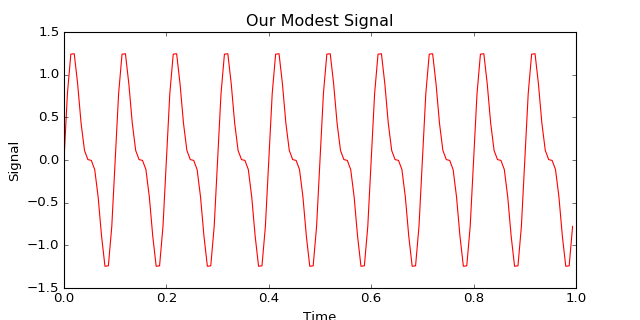

In [12]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(timeVector, ourSignal, 'r')
axes.set_xlabel('Time')
axes.set_ylabel('Signal')
axes.set_title('Our Modest Signal');

<IPython.core.display.Javascript object>


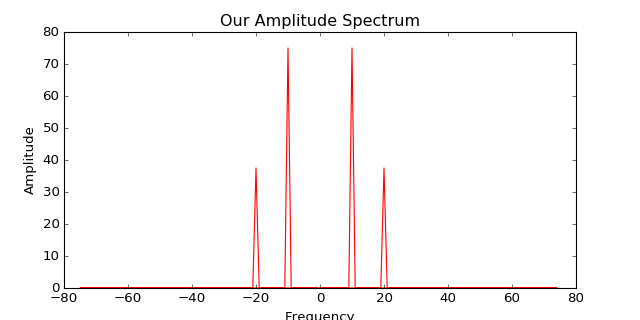

In [13]:
n = ourSignal.size
frequencies = np.fft.fftfreq(n, d=1.0/samplingRate)
spectrum = np.abs(np.fft.fft(ourSignal))

fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.plot(frequencies, spectrum, 'r')

axes.set_xlabel('Frequency')
axes.set_ylabel('Amplitude')
axes.set_title('Our Amplitude Spectrum');

In [15]:
spectrum

array([  1.38559096e-14,   4.05515613e-14,   3.54264847e-14,
         5.79532152e-14,   4.85284063e-14,   3.60339143e-14,
         1.84666950e-14,   2.24979902e-14,   2.75457341e-14,
         1.21121813e-14,   7.50000000e+01,   3.96202771e-14,
         4.42640780e-14,   5.76019209e-14,   2.76561944e-14,
         2.44324078e-14,   3.22051704e-14,   2.56844741e-14,
         3.79522287e-14,   3.29142549e-14,   3.75000000e+01,
         3.27349209e-14,   2.48805884e-14,   2.17117892e-14,
         1.97957818e-14,   1.32332357e-14,   1.38917468e-14,
         4.78001374e-14,   3.88416054e-14,   1.99231690e-14,
         9.72344818e-15,   1.23310744e-14,   2.08536184e-14,
         3.08393295e-14,   8.54672210e-15,   2.88534770e-14,
         1.41668959e-14,   5.85315691e-14,   4.89936839e-14,
         4.00993014e-15,   2.02612842e-14,   1.13813868e-14,
         1.79628550e-14,   3.84132023e-14,   1.76154263e-14,
         3.42133491e-15,   8.93141923e-15,   2.73860203e-14,
         4.04145255e-14,

I'm leaving a few of the implementation details for your discovery.  For example, why are there two peaks in this picture?

[Top of Page](#Sections)

#### Interactive Microscopy Demonstration


`meshgrid` helps us to evaluate functions on a numpy 2D array.  With a little experimentation you'll see the value of this approach.  It will be instructive to make small (e.g. 10x10) arrays and play around with functions on those arrays.  `Numpy` has a lot of methods that will help you solve problems.

In [ ]:
?np.meshgrid

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.fft import *

def atomic_func(x,y):
    param = 64.0
    return (1+np.sin(4*(x+y)*2*np.pi/param))*(1+np.sin(2*(x-2*y)*2*np.pi/param))/4

def aperture(X, Y, xoffset, yoffset, size):
    return (X-xoffset)**2+(Y-yoffset)**2 > size**2

Above we create a couple of helper functions.  The `atomic_func` is our periodic function that you can think of as the density of electrons in a solid.  This is an approximation of our "crystal structure" that we are going to use for our diffraction experiment via the Fourier transform.

The `aperture` function returns `True` or `False` if you are outside or inside the aperture (this seems counterintuitive until you see that we set the elements outside equal to zero).  We also use `meshgrid` to create a two dimensional array to use.

In [ ]:
x = np.arange(0.0,256.0,1.0)
y = np.arange(0.0,256.0,1.0)
X,Y = np.meshgrid(x, y)

Z = atomic_func(X,Y)

Above we map the atomic function.

In [ ]:
P = np.zeros(Z.shape,dtype=complex)
K = np.zeros(Z.shape,dtype=complex)

K = fftshift(fft2(Z, norm='ortho'))

P = np.copy(K)
P[np.where(aperture(X, Y, 128, 128, 3) & aperture(X, Y, 120, 96, 3))] = 0

In this cell we create two more `numpy` arrays (there are other ways to do this) that have the same shape as Z. The `P` array we use to hold the processed Fourier spectrum.  The processing uses `numpy`'s Boolean indexing to set values in P equal to zero when they are "outside" the aperture.  When we get to the images below you'll see what is meant.

Because Python passes by reference we need to call for a copy of K so that we can modify one without changing the other.

From this processed spectrum we will create an image.  The K array holds the whole Fourier spectrum.

In [ ]:
Im = fftshift(ifft2(P))

Above we reprocess `P` into the image `Im`.

In [ ]:
fig0 = plt.figure()
axes0 = fig0.add_axes([0.1, 0.1, 0.8, 0.8])
axes0.imshow(Z, origin='lower')

fig1 = plt.figure()
axes1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
axes1.imshow(abs(K),origin='lower', cmap=plt.get_cmap('pink'))
aperture1 = plt.Circle((128,128),3**2,color='r', fill = False)
aperture2 = plt.Circle((120,96),3**2,color='y', fill = False)
axes1.add_artist(aperture1)
axes1.add_artist(aperture2)

fig2 = plt.figure()
axes2 = fig2.add_axes([0.1, 0.1, 0.8, 0.8])
axes2.imshow(abs(Im)**2, origin='lower')

plt.show()

[Top of Page](#Sections)

# A nice answer

http://dsp.stackexchange.com/a/24058

I'll answer your questions out of order:

3. Negative frequencies do exist. There is nothing controversial about them.

    For a cosine signal: since cos(2π(−f)t)=cos(2πft)

, a cosine of negative frequency −f is equal to a cosine of frequency f

.

Since sin(2π(−f)t)=−sin(2πft)
, a sine of frequency −f is π radians out of phase with respect to a sine of frequency f

.

More importantly, a complex exponential e2πft
can be represented by a point in the complex plane, which rotates counter-clockwise if f is positive and clockwise if f

    is negative.

5. It turns out that, for all physical signals (whose imaginary part is zero), the magnitude spectrum is even (the negative frequencies are a mirror image of the positive frequencies). There is no need to display or calculate them. That's the reason a spectrum analyzer will only display positive frequencies. Complex signals do not have an even magnitude spectrum, and you need to calculate it for negative as well as positive frequencies.

2. Filtering out the negative frequencies is just that: remove the negative frequencies of a signal. The result is a complex signal, because the resulting spectrum is not even. The Hilbert transform you mention at the start of your question is an easy way to implement such a filter. Without it, you'd need a complex filter, which are not trivial to implement and use.

1. There can be many reasons to filter out the negative frequencies of a signal. In digital communications, it is used as one step in obtaining the complex envelope of a modulated signal. In general, a modulated signal looks like s(t)=R[a(t)e2πfct]
, where a(t) is a quadrature signal, and is complex, and where fc is very large (up to several gigahertz). However, the information is contained in a(t), so we would like to recover it from s(t)

. This is accomplished by:

    Filtering out the negative frequencies of s(t)

Downconverting the result to baseband

### Homework
----

1.  Compute the diffraction pattern expected from a double slit experiment.  
1.  Apply the DFT to an image of your choosing.  Select the low frequency part of the DFT and regenerate the image (i.e. take the inverse FFT) from only these selected frequencies.

### Homework Notes
----
Now that we are a few lectures into the course - you are left to set up your own data structures and own methods to solve the problem.  Don't be afraid to delete everything and start over at the early stages of you work.  Keep a pencil and paper handy and sketch ideas before you try and write them in code.  Look for standard solutions to these problems for guidance.

Regarding the second part of the assignment:  Comment on features that are present/absent from the image.  The image can be anything.  You may find it interesting if the image is a pattern.  One possibility is to pull your image from `Lecture-09` since we know those images have structure and patterns in them.

[Top of Page](#Sections)

### Summary
----

* Integral transforms map one function space into another function space.  You can find books that include tables of Laplace and Fourier transforms.  Many other transforms exist - but the principle is the same.
* The DFT organizes amplitude information in predictable yet non-intuitive ways.  Read the documentation for the functions you use!  
* Integral transforms are a means for reducing the complexity of certain ODEs and PDEs.
* Diffraction and diffusion are two example applications where integral transforms can be employed.

[Top of Page](#Sections)

### Looking Ahead
----

As we move into solving ODEs to understand viscoelastic behavior you may notice that it will be possible to apply the Laplace transformation to simplify the problem.  We won't formally do this in class - but it would be a nice exercise to try it for yourself.  Don't be afraid to try out the new techniques you are learning to other application areas.  This is how you gain confidence!

[Top of Page](#Sections)

### Reading Assignments and Practice
----

* Pam Champness' book on electron diffraction is a (relatively) easy read on diffraction.  You can always have a look at Cullity, Hammond, or any other book on structure and X-ray/electron characterization.
* Practice taking the FFT of signals you construct by hand.  This is a good step when you are debugging a problem.  You should always have a test case available to determine if your work is correct.

[Top of Page](#Sections)